<font size="6">
A Study on the Effects of Socio-economic and Educational Mobility Factors on Income Redistribution Preferences<font></font>

Predictive Modelling

## Table of Contents
1. [Predictive and Interpretive Modeling](#1.-Predictive-and-Interpretive-Modeling)
   - [1-1. Data Preparation for Modelling](#1-1.-Data-Preparation-for-Modelling)
   - [1-2. One-vs-All Logistic Regression](#1-2.-One-vs-All-Logistic-Regression)
   - [1-3. Naïve Bayes](#1-3.-Naïve-Bayes)
   - [1-4. Ensemble Methods](#1-4.-Ensemble-Methods)
   - [1-5. Interpretive Modelling Analysis](#1-5.-Interpretive-Modelling-Analysis)
     - [1-5-1. Standard Logistic Regression Interpretation](#1-5-1.-Standard-Logistic-Regression-Interpretation)
     - [1-5-2. K-Fold Cross-Validation for Model Robustness](#1-5-2.-K-Fold-Cross-Validation-for-Model-Robustness)
     - [1-5-3. Hyperparameter Tuning with GridSearchCV](#1-5-3.-Hyperparameter-Tuning-with-GridSearchCV)
2. [Limitations](#2.-Limitations)



## 1. Predictive and Interpretive Modeling
<a id="predictive-analysis"></a>

In this study, the objective is twofold: firstly, to predict individuals' attitudes towards income redistribution based on various socioeconomic factors; and secondly, to interpret how these factors, particularly educational mobility, influence these attitudes. Given the categorical nature of the dependent variable (`inc_redist`), which captures respondents' stances as **"Agree," "Neutral," or "Disagree,"** a classification approach is appropriate. Initially, a **One-vs-All Logistic Regression** was employed due to its interpretability and suitability for multi-class problems. However, recognizing potential limitations in predictive performance, especially in the presence of class imbalance, alternative models such as **Naïve Bayes** and **ensemble methods** were explored to enhance accuracy.

### 1-1 Data Preparation for Modelling
<a id="data preparation for modelling"></a>

In [57]:
!pip install statsmodels
!pip install imblearn
!pip install ace_tools

# Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE

# Load the Data
data_path = "cleaned_combined_data_1.csv"
combined_data = pd.read_csv(data_path)

In [58]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Data Processing & Cleaning

# Create new feature
combined_data['age_squared'] = combined_data['agea'] ** 2

# Drop rows where critical variables are missing
critical_vars = ["educ_mob_avg_category"]  # Dependent variable & key predictor
combined_data = combined_data.dropna(subset=critical_vars)

# Impute missing values for secondary variables
continuous_vars = ["agea", "age_squared", "wkhtot"]  
for var in continuous_vars:
    combined_data[var].fillna(combined_data[var].median(), inplace=True)

categorical_vars = ["domicile", "unemp_nuts2", "EQI", "gender", "resp_ed", "income_decile",
                    "child_ever", "marital_status", "unemp_ever", "union_member", "gov_trust", "equality_importance"]
for var in categorical_vars:
    combined_data[var].fillna(combined_data[var].mode()[0], inplace=True)

# Add Social Attitudes Variables and Interaction Terms
combined_data['gov_trust_mob'] = combined_data['gov_trust'] * combined_data['educ_mob_avg']
combined_data['equality_mob'] = combined_data['equality_importance'] * combined_data['educ_mob_avg']

# Handle missing values for social attitudes
combined_data['gov_trust'].fillna(combined_data['gov_trust'].mode()[0], inplace=True)
combined_data['equality_importance'].fillna(combined_data['equality_importance'].mode()[0], inplace=True)

# Encode categorical variables
for cat_var in categorical_vars:
    combined_data[cat_var] = LabelEncoder().fit_transform(combined_data[cat_var])

# Standardize Continuous Variables
scaler = StandardScaler()
combined_data[continuous_vars] = scaler.fit_transform(combined_data[continuous_vars])

/var/folders/8_/b04pl0w94mg7rjmbvrtzsd6w0000gn/T/ipykernel_89811/26004395.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data[var].fillna(combined_data[var].median(), inplace=True)
/var/folders/8_/b04pl0w94mg7rjmbvrtzsd6w0000gn/T/ipykernel_89811/26004395.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [61]:
# Define Variables

dependent_var = "inc_redist"
main_predictor = ["educ_mob_avg"]
main_predictor_cat = ["educ_mob_avg_category"]
control_vars = ["agea", "age_squared", "gender", "resp_ed", "income_decile",
                "child_ever", "marital_status", "unemp_ever", "union_member"]
regional_factors = ["domicile", "unemp_nuts2", "EQI"]
hours_worked = ["wkhtot"]
social_attitudes = ["gov_trust", "equality_importance"]
interaction_terms = ["gov_trust_mob", "equality_mob"]

# Handle Multicollinearity (VIF)

def calculate_vif(X):
    """Calculate Variance Inflation Factor (VIF) for each feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Define relevant features (EXCLUDE ID-like variables)
feature_columns = [
    "educ_mob_avg", "agea", "age_squared", "gender", "resp_ed", "income_decile",
    "child_ever", "marital_status", "unemp_ever", "union_member", "domicile",
    "unemp_nuts2", "EQI", "wkhtot", "gov_trust", "equality_importance",
    "gov_trust_mob", "equality_mob"
]

X_vif = combined_data[feature_columns].copy()

# Compute initial VIF
vif_df = calculate_vif(X_vif)
print("VIF Before Removing Multicollinearity:\n", vif_df)

# Drop high VIF features ("agea", "gov_trust", "equality_importance")
features_to_drop = ["agea", "gov_trust", "equality_importance"]
X_vif_filtered = X_vif.drop(columns=features_to_drop)

# Recompute VIF after removal
vif_df_after = calculate_vif(X_vif_filtered)
print("\nVIF After Removing High Multicollinearity Features:\n", vif_df_after)


VIF Before Removing Multicollinearity:
                 Feature         VIF
0          educ_mob_avg  102.567335
1                  agea   48.636602
2           age_squared   48.759839
3                gender    2.332810
4               resp_ed    8.355897
5         income_decile    6.023199
6            child_ever    4.465641
7        marital_status    1.701690
8            unemp_ever    1.452398
9          union_member    1.226919
10             domicile    3.823176
11          unemp_nuts2    3.697469
12                  EQI    3.438543
13               wkhtot    1.037974
14            gov_trust   32.670830
15  equality_importance   27.267449
16        gov_trust_mob   35.394955
17         equality_mob  146.265903

VIF After Removing High Multicollinearity Features:
            Feature        VIF
0     educ_mob_avg  29.996155
1      age_squared   1.526960
2           gender   2.273141
3          resp_ed   8.209621
4    income_decile   5.555781
5       child_ever   4.111970
6   marital_

In [63]:
# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif_filtered)  # Standardize feature set
X_scaled_df = pd.DataFrame(X_scaled, columns=X_vif_filtered.columns)
print("\nScaled Feature Set (First 5 rows):\n", X_scaled_df.head())


Scaled Feature Set (First 5 rows):
    educ_mob_avg  age_squared    gender   resp_ed  income_decile  child_ever  \
0     -0.255808     0.078046 -1.096755  0.967009       0.495799   -1.693178   
1     -0.255808     0.279249 -1.096755  1.516674       0.098739   -1.693178   
2      0.955778    -0.625320  0.911780  0.417344       0.098739    0.590605   
3     -0.558704     0.943728  0.911780 -0.681985       1.289918    0.590605   
4      2.470260    -0.174445 -1.096755  1.516674       1.289918    0.590605   

   marital_status  unemp_ever  union_member  domicile  unemp_nuts2       EQI  \
0       -0.558222   -0.596020     -0.359603  0.889474     1.613160  0.456530   
1       -0.558222    1.677797      2.780844 -0.765942    -0.537866  1.350199   
2       -0.558222    1.677797      2.780844 -1.593649    -1.613379  1.350199   
3        1.332240    1.677797     -0.359603  0.889474     2.688674  0.456530   
4       -0.558222   -0.596020     -0.359603  0.061766    -1.613379  1.350199   

     wk

In [65]:
# Train-Test Split
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load your dataset
X = X_scaled_df  # Assuming X_scaled_df is your scaled feature matrix
y = combined_data["inc_redist"]  # Target variable

# Train-Test Split (DO THIS ONCE)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Save indices to ensure consistency
train_indices = X_train_full.index
test_indices = X_test_full.index

print(f"Train size: {X_train_full.shape}, Test size: {X_test_full.shape}")


Train size: (13742, 15), Test size: (5890, 15)


In [67]:
# Feature Selection 
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

def apply_feature_selection(X_train, X_test, y_train, method="mutual_info", num_features=10):
    """ Selects top features based on the specified method and applies to both train & test sets. """

    if method == "mutual_info":
        # Mutual Information Feature Selection
        selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)  # Apply the same transformation to the test set

        # Retrieve selected feature names
        selected_features = X_train.columns[selector.get_support()]
        
        # Convert NumPy array back to DataFrame
        X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
        X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

    elif method == "RFE":
        # Recursive Feature Elimination (RFE)
        logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500, class_weight="balanced")
        selector = RFE(logreg, n_features_to_select=num_features, step=1)
        selector.fit(X_train, y_train)
        selected_idx = np.where(selector.support_)[0]  # Get selected feature indices

        # Retrieve selected feature names
        selected_features = X_train.columns[selected_idx]

        # Subset the DataFrame to selected features
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

    else:
        raise ValueError("Unsupported feature selection method")

    print(f"🔹 Selected {num_features} Features: {list(selected_features)}")

    return X_train_selected, X_test_selected, selected_features


# Apply feature selection (Change method to 'mutual_info' or 'RFE' as needed)
X_train, X_test, selected_features = apply_feature_selection(
    X_train_full, X_test_full, y_train, method="RFE", num_features=10
)


🔹 Selected 10 Features: ['educ_mob_avg', 'resp_ed', 'income_decile', 'marital_status', 'unemp_ever', 'unemp_nuts2', 'EQI', 'wkhtot', 'gov_trust_mob', 'equality_mob']


### 1-2 One-vs-All Logistic Regression
<a id="one-vs-all logistic regression"></a>

The first attempt involved using a One-vs-All Logistic Regression model, where separate binary logistic models were trained for each category. This approach yielded an accuracy of approximately **74%**, but a deeper examination of the results revealed a significant limitation: the model was highly effective in predicting the **"Agree"** class while failing to classify **"Neutral"** and **"Disagree"** categories properly. 

Essentially, the model was merely mirroring the distribution of `inc_redist`, as most respondents supported redistribution. This class imbalance issue caused the model to disproportionately favor the majority class, rendering predictions for neutral and disagree cases highly inaccurate. 

The poor predictive power for these categories suggested that a logistic regression model, in its basic form, was insufficient for capturing nuanced relationships between predictors and all outcome classes.


In [70]:
# ===========================================
# Train One-vs-All Logistic Regression Models
# ===========================================

# Convert multi-class target to binary for each class
y_train_agree = (y_train == 1).astype(int)
y_train_neutral = (y_train == 2).astype(int)
y_train_disagree = (y_train == 3).astype(int)

y_test_agree = (y_test == 1).astype(int)
y_test_neutral = (y_test == 2).astype(int)
y_test_disagree = (y_test == 3).astype(int)

# Initialize logistic regression model
logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500, class_weight="balanced")

# Train separate models
model_agree = logreg.fit(X_train, y_train_agree)
model_neutral = logreg.fit(X_train, y_train_neutral)
model_disagree = logreg.fit(X_train, y_train_disagree)



🔹 Classification Report for Agree vs. Others
              precision    recall  f1-score   support

           0       0.18      0.42      0.25      1507
           1       0.62      0.33      0.43      4383

    accuracy                           0.35      5890
   macro avg       0.40      0.38      0.34      5890
weighted avg       0.51      0.35      0.39      5890



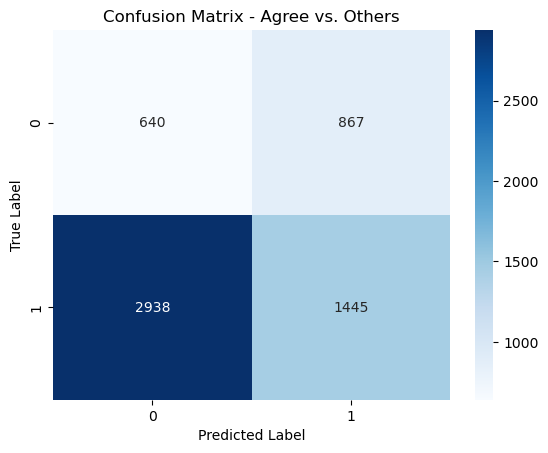


🔹 Classification Report for Neutral vs. Others
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      5014
           1       0.20      0.53      0.29       876

    accuracy                           0.62      5890
   macro avg       0.54      0.58      0.51      5890
weighted avg       0.78      0.62      0.67      5890



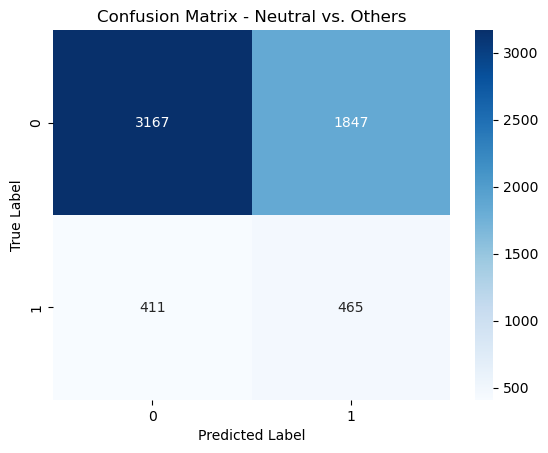


🔹 Classification Report for Disagree vs. Others
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      5259
           1       0.17      0.64      0.27       631

    accuracy                           0.64      5890
   macro avg       0.55      0.64      0.52      5890
weighted avg       0.85      0.64      0.71      5890



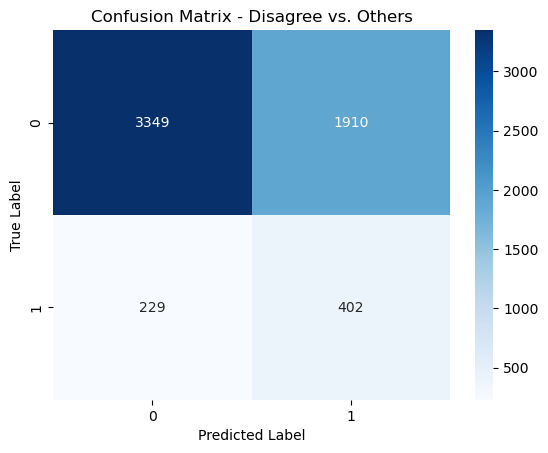

In [72]:
# Evaluate Performance
def evaluate_model(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    print(f"\n🔹 Classification Report for {label} vs. Others")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {label} vs. Others")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate all three models
evaluate_model(model_agree, X_test, y_test_agree, "Agree")
evaluate_model(model_neutral, X_test, y_test_neutral, "Neutral")
evaluate_model(model_disagree, X_test, y_test_disagree, "Disagree")



🔹 One-vs-All (OvA) Multi-Class Accuracy: 0.7441


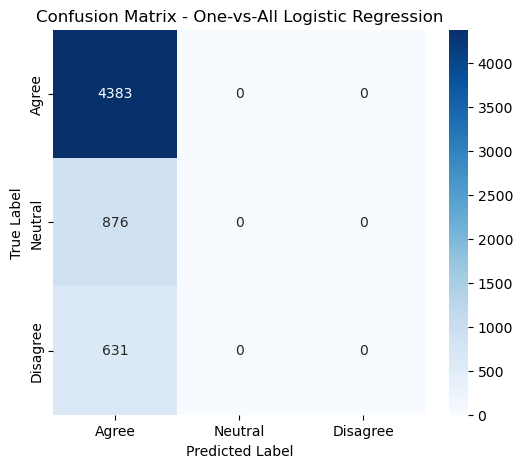

In [74]:
# Overall Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get Probabilities Instead of Binary Predictions
y_prob_agree = model_agree.predict_proba(X_test)[:, 1]  # Probability of being "Agree"
y_prob_neutral = model_neutral.predict_proba(X_test)[:, 1]  # Probability of being "Neutral"
y_prob_disagree = model_disagree.predict_proba(X_test)[:, 1]  # Probability of being "Disagree"

# Stack Probabilities to Identify the Class with the Highest Confidence
y_prob_stack = np.vstack([y_prob_agree, y_prob_neutral, y_prob_disagree]).T

# Assign Final Predicted Label as the Class with Maximum Probability
y_pred_final = np.argmax(y_prob_stack, axis=1) + 1  # Adding 1 to match class labels {1,2,3}

# Compute One-vs-All Accuracy
ova_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n🔹 One-vs-All (OvA) Multi-Class Accuracy: {ova_accuracy:.4f}")

# Compute One-vs-All Confusion Matrix
cm_ova = confusion_matrix(y_test, y_pred_final)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ova, annot=True, fmt="d", cmap="Blues", xticklabels=["Agree", "Neutral", "Disagree"], yticklabels=["Agree", "Neutral", "Disagree"])
plt.title("Confusion Matrix - One-vs-All Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 1-3 Naïve Bayes
<a id="naïve bayes"></a>


Given the poor performance of logistic regression on minority classes, the next attempt involved **Naïve Bayes**, a probabilistic classifier well-suited for high-dimensional data. While accuracy slightly decreased, classification for the **"Neutral"** and **"Disagree"** categories improved marginally. 

The improvement in predicting underrepresented classes scourced from **Naïve Bayes' reliance on probability distributions** rather than purely fitting decision boundaries. However, Naïve Bayes still struggled with precision for the **"Neutral"** class, indicating that linear assumptions might not sufficiently capture the complexity of the relationships in the data.


In [77]:
# =================================
# Change Model to Naïve Bayes Model
# =================================

from sklearn.naive_bayes import GaussianNB

# Define the Naïve Bayes Model
nb_model = GaussianNB()

# Convert multi-class target to binary for each class
y_train_agree = (y_train == 1).astype(int)
y_train_neutral = (y_train == 2).astype(int)
y_train_disagree = (y_train == 3).astype(int)

y_test_agree = (y_test == 1).astype(int)
y_test_neutral = (y_test == 2).astype(int)
y_test_disagree = (y_test == 3).astype(int)

# Train Separate One-vs-All Models
model_agree = nb_model.fit(X_train, y_train_agree)
model_neutral = nb_model.fit(X_train, y_train_neutral)
model_disagree = nb_model.fit(X_train, y_train_disagree)




🔹 Classification Report for Agree vs. Others
              precision    recall  f1-score   support

           0       0.25      0.99      0.40      1507
           1       0.36      0.00      0.01      4383

    accuracy                           0.25      5890
   macro avg       0.31      0.49      0.20      5890
weighted avg       0.34      0.25      0.11      5890



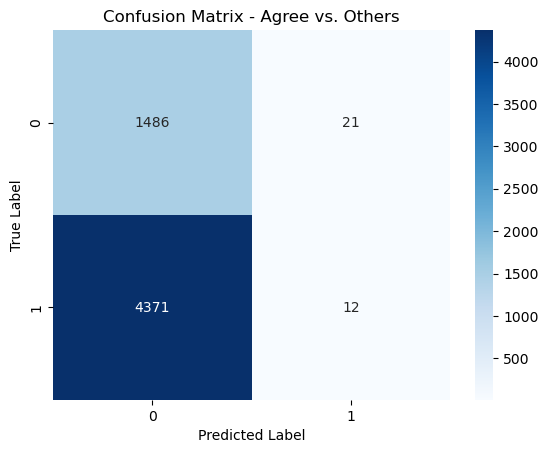


🔹 Classification Report for Neutral vs. Others
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      5014
           1       0.30      0.01      0.02       876

    accuracy                           0.85      5890
   macro avg       0.58      0.50      0.47      5890
weighted avg       0.77      0.85      0.78      5890



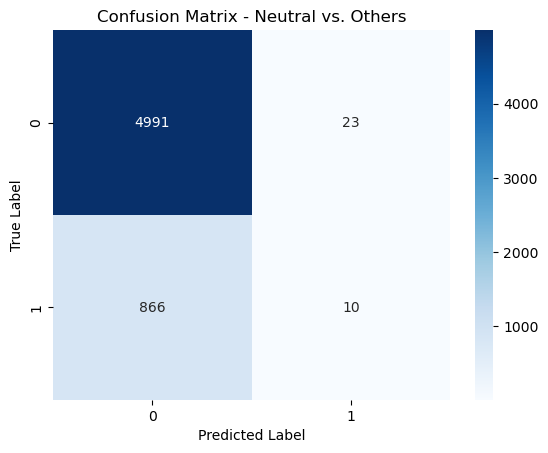


🔹 Classification Report for Disagree vs. Others
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5259
           1       0.33      0.02      0.03       631

    accuracy                           0.89      5890
   macro avg       0.61      0.51      0.49      5890
weighted avg       0.83      0.89      0.84      5890



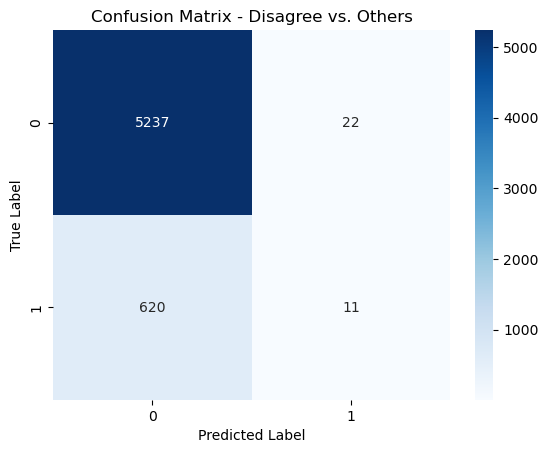

In [79]:
# Evaluate Performance
def evaluate_model(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    print(f"\n🔹 Classification Report for {label} vs. Others")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {label} vs. Others")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate all three models
evaluate_model(model_agree, X_test, y_test_agree, "Agree")
evaluate_model(model_neutral, X_test, y_test_neutral, "Neutral")
evaluate_model(model_disagree, X_test, y_test_disagree, "Disagree")

In [81]:
# Overall Evaluation with Optimized Threshold
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curves
prec_agree, rec_agree, thresholds_agree = precision_recall_curve(y_test_agree, y_prob_agree)
prec_neutral, rec_neutral, thresholds_neutral = precision_recall_curve(y_test_neutral, y_prob_neutral)
prec_disagree, rec_disagree, thresholds_disagree = precision_recall_curve(y_test_disagree, y_prob_disagree)

# Compute F1 score for each threshold
f1_scores_agree = 2 * (prec_agree * rec_agree) / (prec_agree + rec_agree + 1e-9)
f1_scores_neutral = 2 * (prec_neutral * rec_neutral) / (prec_neutral + rec_neutral + 1e-9)
f1_scores_disagree = 2 * (prec_disagree * rec_disagree) / (prec_disagree + rec_disagree + 1e-9)

# Select threshold with highest F1 score
best_threshold_agree = thresholds_agree[np.argmax(f1_scores_agree)]
best_threshold_neutral = thresholds_neutral[np.argmax(f1_scores_neutral)]
best_threshold_disagree = thresholds_disagree[np.argmax(f1_scores_disagree)]

print(f"🔹 Optimized Threshold for Agree: {best_threshold_agree:.3f}")
print(f"🔹 Optimized Threshold for Neutral: {best_threshold_neutral:.3f}")
print(f"🔹 Optimized Threshold for Disagree: {best_threshold_disagree:.3f}")



🔹 Optimized Threshold for Agree: 0.094
🔹 Optimized Threshold for Neutral: 0.455
🔹 Optimized Threshold for Disagree: 0.580



🔹 One-vs-All (OvA) Multi-Class Accuracy After Threshold Adjustment: 0.6638


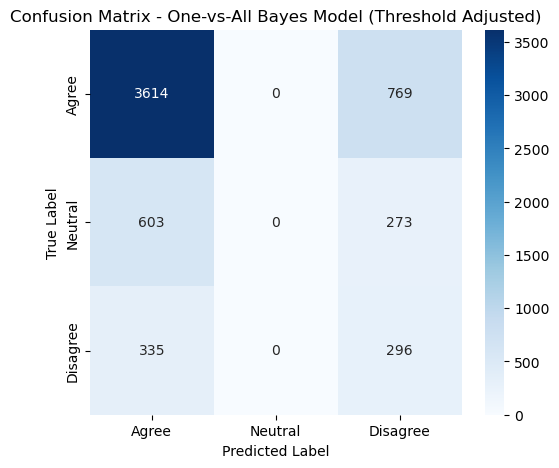

In [83]:
# Initialize predictions to class "Neutral" (default)
y_pred_final = np.full(len(X_test), 2)  # Neutral as default (Class 2)

# Assign class if probability exceeds the threshold
y_pred_final[y_prob_agree >= best_threshold_agree] = 1  # Assign "Agree" if threshold met
y_pred_final[y_prob_disagree >= best_threshold_disagree] = 3  # Assign "Disagree" if threshold met

# Compute One-vs-All Accuracy
ova_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n🔹 One-vs-All (OvA) Multi-Class Accuracy After Threshold Adjustment: {ova_accuracy:.4f}")

# Compute One-vs-All Confusion Matrix
cm_ova = confusion_matrix(y_test, y_pred_final)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ova, annot=True, fmt="d", cmap="Blues", xticklabels=["Agree", "Neutral", "Disagree"], yticklabels=["Agree", "Neutral", "Disagree"])
plt.title("Confusion Matrix - One-vs-All Bayes Model (Threshold Adjusted)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 1-4 Ensemble Methods
<a id="ensemble methods"></a>

In [85]:
# Apply feature selection (Change method to 'mutual_info')
X_train, X_test, selected_features = apply_feature_selection(
    X_train_full, X_test_full, y_train, method="mutual_info", num_features=10
)


🔹 Selected 10 Features: ['educ_mob_avg', 'resp_ed', 'income_decile', 'child_ever', 'unemp_ever', 'unemp_nuts2', 'EQI', 'wkhtot', 'gov_trust_mob', 'equality_mob']


In [87]:
# Define One-vs-All Target Variables
ova_targets = {
    "Agree": ((y_train == 1).astype(int), (y_test == 1).astype(int)),
    "Neutral": ((y_train == 2).astype(int), (y_test == 2).astype(int)),
    "Disagree": ((y_train == 3).astype(int), (y_test == 3).astype(int)),
}

# Store binary datasets
ova_targets = {
    "Agree vs Others": (y_train_agree, y_test_agree),
    "Neutral vs Others": (y_train_neutral, y_test_neutral),
    "Disagree vs Others": (y_train_disagree, y_test_disagree)
}

Recognizing the inefficiency of training models separately, a **multi-model pipeline** was introduced, allowing simultaneous training of **Logistic Regression, Naïve Bayes, SVM, and Random Forest**. This approach streamlined the process while allowing a direct comparison among different models. 

The best-performing configuration emerged as a **combination of Random Forest for "Agree"** and **Naïve Bayes for "Neutral" and "Disagree"**. Final accuracy reached **60.12%**, showing an improvement over Naïve Bayes alone but still indicating room for better classification, particularly for the **"Neutral"** class, which remained challenging to predict accurately.


In [95]:
# =========================================
# Define and Train Multiple Models
# =========================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Define models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel="linear", probability=True, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
}
# Store results
model_results = {}

# Train models for each One-vs-All classification task
for class_label, (y_train_binary, y_test_binary) in ova_targets.items():
    print(f"\n🔹 Evaluating models for {class_label}")

    for name, model in models.items():
        print(f"\n🔸 {name} - {class_label}")

        # Create pipeline (scaling + model)
        pipeline = Pipeline([
            ("scaler", StandardScaler()),  # Scale features for all models
            ("classifier", model)
        ])

        # Train model
        pipeline.fit(X_train, y_train_binary)

        # Predict and evaluate
        y_pred_binary = pipeline.predict(X_test)

        # Store results
        model_results[(name, class_label)] = {
            "model": pipeline,
            "y_pred": y_pred_binary,
            "accuracy": accuracy_score(y_test_binary, y_pred_binary),
            "f1_score": f1_score(y_test_binary, y_pred_binary)
        }

        # Print classification report
        print(classification_report(y_test_binary, y_pred_binary))



🔹 Evaluating models for Agree vs Others

🔸 KNN - Agree vs Others
              precision    recall  f1-score   support

           0       0.41      0.23      0.30      1507
           1       0.77      0.89      0.82      4383

    accuracy                           0.72      5890
   macro avg       0.59      0.56      0.56      5890
weighted avg       0.68      0.72      0.69      5890


🔸 Naive Bayes - Agree vs Others
              precision    recall  f1-score   support

           0       0.42      0.16      0.23      1507
           1       0.76      0.93      0.84      4383

    accuracy                           0.73      5890
   macro avg       0.59      0.54      0.53      5890
weighted avg       0.68      0.73      0.68      5890


🔸 SVM - Agree vs Others
              precision    recall  f1-score   support

           0       0.36      0.61      0.45      1507
           1       0.82      0.62      0.71      4383

    accuracy                           0.62      5890
   m

,Model,Class,Accuracy,F1-Score
0,KNN,Agree vs Others,0.719185,0.824453
1,Naive Bayes,Agree vs Others,0.729881,0.836266
2,SVM,Agree vs Others,0.617997,0.707108
3,Random Forest,Agree vs Others,0.733616,0.835414
4,KNN,Neutral vs Others,0.832088,0.106594
5,Naive Bayes,Neutral vs Others,0.842105,0.064386
6,SVM,Neutral vs Others,0.584380,0.295742
7,Random Forest,Neutral vs Others,0.830730,0.086159
8,KNN,Disagree vs Others,0.887946,0.138381
9,Naive Bayes,Disagree vs Others,0.890832,0.030166


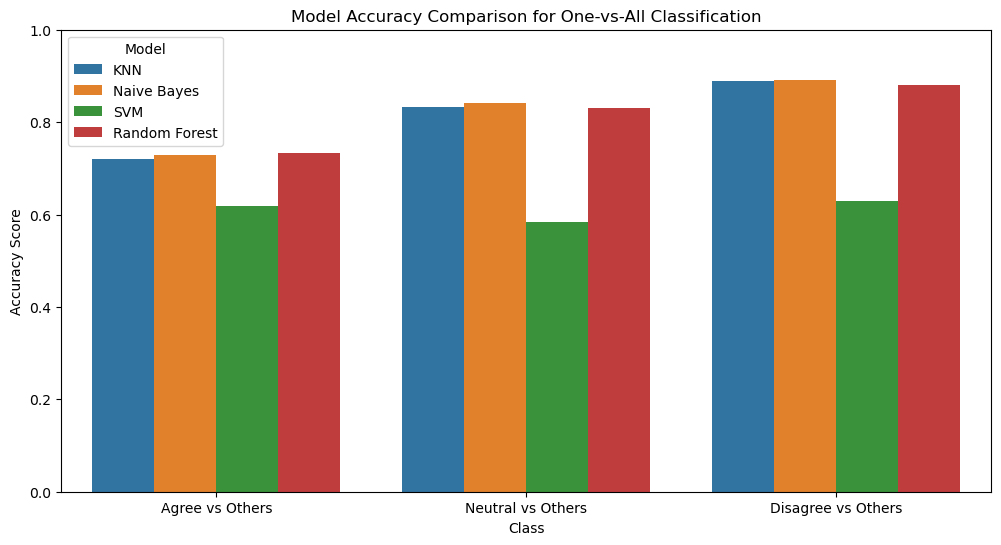

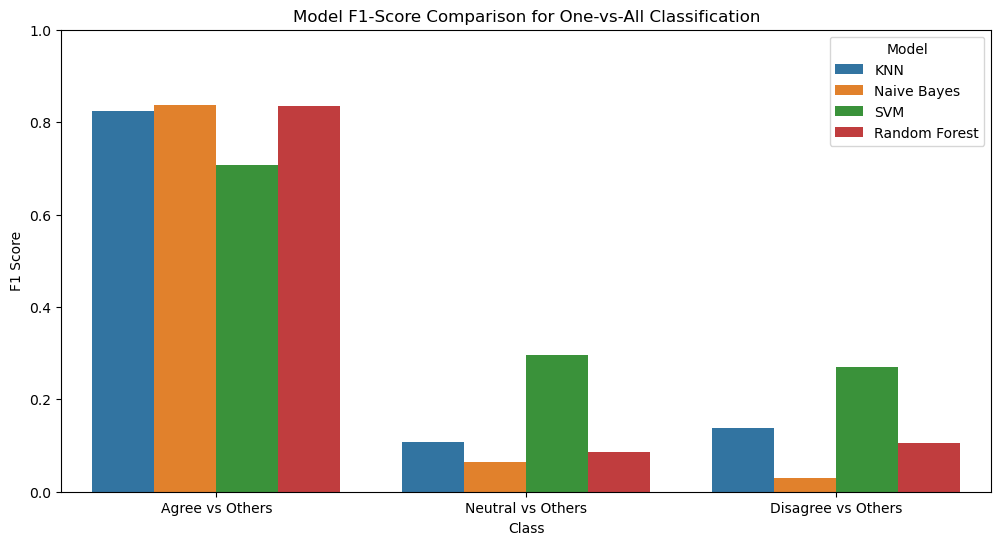

In [97]:
# Extract evaluation metrics for each model and class
evaluation_results = []
for (model_name, class_label), metrics in model_results.items():
    evaluation_results.append({
        "Model": model_name,
        "Class": class_label,
        "Accuracy": metrics["accuracy"],
        "F1-Score": metrics["f1_score"]
    })

# Convert to DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_results)

# Display the evaluation metrics
from IPython.display import display
display(evaluation_df)

# Plot Accuracy and F1-score Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Accuracy", hue="Model", data=evaluation_df)
plt.title("Model Accuracy Comparison for One-vs-All Classification")
plt.xlabel("Class")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="F1-Score", hue="Model", data=evaluation_df)
plt.title("Model F1-Score Comparison for One-vs-All Classification")
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.show()

In [99]:
# Best Model Decision
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Explicitly assign models for each One-vs-All task
model_agree = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)  # Random Forest
model_neutral = GaussianNB()  # Naïve Bayes
model_disagree = GaussianNB()  # Naïve Bayes

# Train models with the correct assignments
model_agree.fit(X_train, y_train_agree)
model_neutral.fit(X_train, y_train_neutral)
model_disagree.fit(X_train, y_train_disagree)


GaussianNB()

In [101]:
# Get predicted probabilities using the correct models
y_prob_agree = model_agree.predict_proba(X_test)[:, 1]  # Random Forest
y_prob_neutral = model_neutral.predict_proba(X_test)[:, 1]  # Naïve Bayes
y_prob_disagree = model_disagree.predict_proba(X_test)[:, 1]  # Naïve Bayes


🔹 Optimized Threshold for Agree: 0.179
🔹 Optimized Threshold for Neutral: 0.114
🔹 Optimized Threshold for Disagree: 0.130

✅ Overall One-vs-All Accuracy (After Thresholding): 0.6012


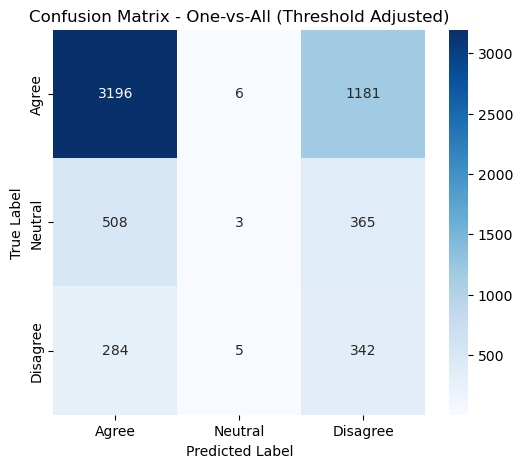

In [106]:
# Overal Evaluation with Optimized Threshold
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute precision-recall curves
prec_agree, rec_agree, thresholds_agree = precision_recall_curve(y_test_agree, y_prob_agree)
prec_neutral, rec_neutral, thresholds_neutral = precision_recall_curve(y_test_neutral, y_prob_neutral)
prec_disagree, rec_disagree, thresholds_disagree = precision_recall_curve(y_test_disagree, y_prob_disagree)

# Compute F1 score for each threshold
f1_scores_agree = 2 * (prec_agree * rec_agree) / (prec_agree + rec_agree + 1e-9)
f1_scores_neutral = 2 * (prec_neutral * rec_neutral) / (prec_neutral + rec_neutral + 1e-9)
f1_scores_disagree = 2 * (prec_disagree * rec_disagree) / (prec_disagree + rec_disagree + 1e-9)

# Select threshold with highest F1 score
best_threshold_agree = thresholds_agree[np.argmax(f1_scores_agree)]
best_threshold_neutral = thresholds_neutral[np.argmax(f1_scores_neutral)]
best_threshold_disagree = thresholds_disagree[np.argmax(f1_scores_disagree)]

print(f"🔹 Optimized Threshold for Agree: {best_threshold_agree:.3f}")
print(f"🔹 Optimized Threshold for Neutral: {best_threshold_neutral:.3f}")
print(f"🔹 Optimized Threshold for Disagree: {best_threshold_disagree:.3f}")


# APPLY THRESHOLD TO FINAL CLASSIFICATION

# Initialize predictions to "Neutral" (Class 2) as the default class
y_pred_final = np.full(len(X_test), 2)  # Default to Neutral

# Apply thresholding based on best F1 score thresholds
y_pred_final[y_prob_agree > best_threshold_agree] = 1   # Assign "Agree" if threshold met
y_pred_final[y_prob_disagree > best_threshold_disagree] = 3  # Assign "Disagree" if threshold met


# EVALUATE FINAL MODEL PERFORMANCE

# Compute One-vs-All Accuracy
overall_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n✅ Overall One-vs-All Accuracy (After Thresholding): {overall_accuracy:.4f}")

# Compute One-vs-All Confusion Matrix
cm_ova = confusion_matrix(y_test, y_pred_final)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ova, annot=True, fmt="d", cmap="Blues", xticklabels=["Agree", "Neutral", "Disagree"], yticklabels=["Agree", "Neutral", "Disagree"])
plt.title("Confusion Matrix - One-vs-All (Threshold Adjusted)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

From Predictive modelling, **class imbalance** issue was noticed.

Efforts to mitigate **class imbalance** included techniques such as **Synthetic Minority Over-sampling Technique (SMOTE)** and **class weighting** during model training. However, these methods did not yield improved results and, in some cases, worsened performance. 

This outcome aligns with findings in the literature, where certain **imbalance correction methods** can distort model calibration and lead to **inaccurate probability estimates**. Given the real-world distribution of **attitudes towards income redistribution**, these techniques may not be suitable, as they could artificially alter the inherent data structure.


### 1-5 Interpretive Modelling Analysis
<a id="interpretive modelling"></a>

The **interpretive analysis** in this study focuses on understanding the role of **educational mobility** and key **socioeconomic factors** in shaping attitudes toward **income redistribution**, while controlling for **potential confounders**. 

Unlike **predictive modeling**, which prioritizes **classification accuracy**, the **interpretive models** aim to extract **meaningful insights** into how different features influence the likelihood of respondents **agreeing, remaining neutral, or disagreeing** with redistribution policies.


### 1-5-1 Standard Logistic Regression Interpretation
<a id="standard logistic regression interpretation"></a>

The first approach involved training a **One-vs-All Logistic Regression** model to estimate how **socioeconomic factors** influence attitudes toward **income redistribution**. This model was chosen for its **interpretability**, as each **coefficient** represents the **log-odds change** associated with a **one-unit increase** in the predictor variable, holding other factors constant.

The results highlighted **three key insights**:
1. **Educational mobility** was **positively associated** with support for redistribution, suggesting that those who experienced **upward mobility** recognize the role of **redistributive policies** in enabling economic progress.
2. **Higher-income individuals** were **significantly less likely** to support redistribution, aligning with **self-interest theories** that predict opposition to policies that may lead to **higher taxes** or **wealth transfers**.
3. **Trust in government** emerged as a **strong predictor**, reinforcing that individuals who have **confidence in state institutions** are more likely to believe in the **fairness and effectiveness** of redistributive policies.

However, while these **coefficients provide valuable insights**, logistic regression operates under the assumption of **linearity in the log-odds space** and does not account for potential **interactions** or **nonlinear effects** between predictors.


In [112]:
# Apply feature selection (Change method to 'RFE' as needed)
X_train_selected, X_test_selected, selected_features = apply_feature_selection(
    X_train_full, X_test_full, y_train, method="RFE", num_features=10
)

# Convert to DataFrame for statsmodels
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)


🔹 Selected 10 Features: ['educ_mob_avg', 'resp_ed', 'income_decile', 'marital_status', 'unemp_ever', 'unemp_nuts2', 'EQI', 'wkhtot', 'gov_trust_mob', 'equality_mob']


In [114]:
# =======================================
# Compute Coefficients for Interpretation
# =======================================
import statsmodels.api as sm

# Train Models
ova_models = {}

for class_label, (y_train_binary, y_test_binary) in ova_targets.items():
    print(f"\n🔹 Training Logistic Regression for {class_label}")

    # Ensure indices are aligned
    X_train_sm = sm.add_constant(X_train_selected_df).reset_index(drop=True)
    y_train_binary = y_train_binary.reset_index(drop=True)

    # Fit Logistic Regression
    model = sm.Logit(y_train_binary, X_train_sm).fit()

    # Store model
    ova_models[class_label] = model

    # Print summary
    print(model.summary())



🔹 Training Logistic Regression for Agree vs Others
Optimization terminated successfully.
         Current function value: 0.531772
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             inc_redist   No. Observations:                13742
Model:                          Logit   Df Residuals:                    13731
Method:                           MLE   Df Model:                           10
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                 0.06477
Time:                        02:21:10   Log-Likelihood:                -7307.6
converged:                       True   LL-Null:                       -7813.7
Covariance Type:            nonrobust   LLR p-value:                4.328e-211
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1638      0.021     54.922 


🔹 Evaluating Agree vs Others
✅ Accuracy for Agree vs Others: 0.7501


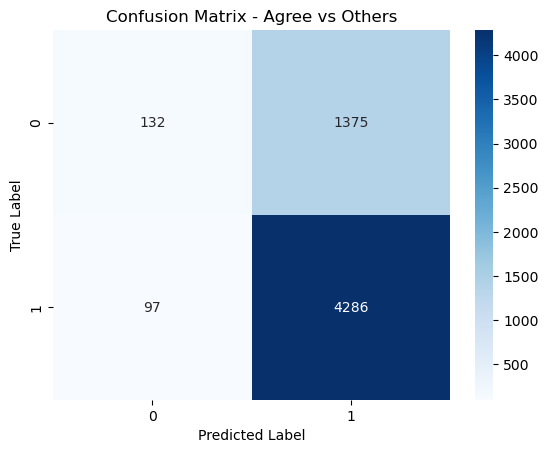


🔹 Evaluating Neutral vs Others
✅ Accuracy for Neutral vs Others: 0.8514


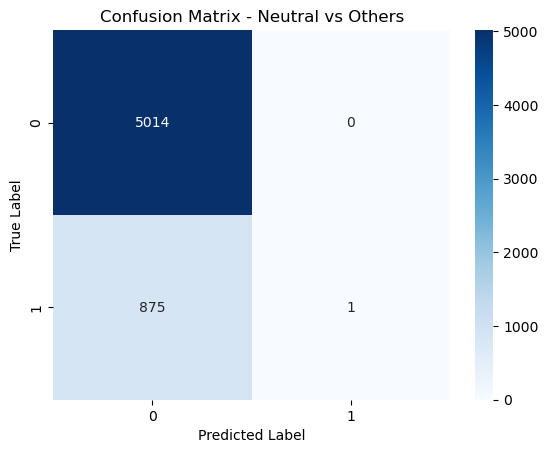


🔹 Evaluating Disagree vs Others
✅ Accuracy for Disagree vs Others: 0.8929


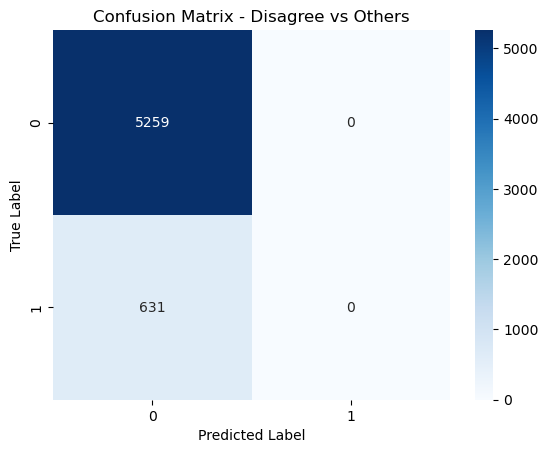

In [116]:
# Each Model Performance
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure `X_test_selected_df` is correctly defined
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)

# Predict & Evaluate Each Model
for class_label, model in ova_models.items():
    print(f"\n🔹 Evaluating {class_label}")

    # Ensure constant is added to match training input
    X_test_sm = sm.add_constant(X_test_selected_df).reset_index(drop=True)

    # Get the correct binary test labels from `ova_targets`
    y_test_binary = ova_targets[class_label][1].reset_index(drop=True)

    # Predict probabilities
    y_pred_prob = model.predict(X_test_sm)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Default threshold 0.5

    # Compute Accuracy
    acc = accuracy_score(y_test_binary, y_pred_binary)
    print(f"✅ Accuracy for {class_label}: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {class_label}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()



✅ Overall One-vs-All Accuracy: 0.5462


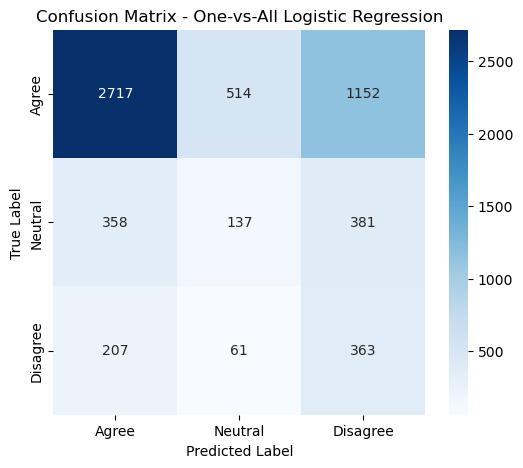

In [118]:
# Overall Evaluation with Optimized Threshold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

# Function to compute the best threshold based on Youden's J statistic
def find_best_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    youden_j = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_j)]
    return best_threshold

# Initialize final predictions to Neutral (Class 2) as default
y_pred_final = np.full(len(X_test_selected_df), 2)  # Default to Neutral

# Add constant to test set for statsmodels prediction
X_test_sm = sm.add_constant(X_test_selected_df)

# Predict probabilities using best models
y_prob_agree = ova_models["Agree vs Others"].predict(X_test_sm)
y_prob_neutral = ova_models["Neutral vs Others"].predict(X_test_sm)
y_prob_disagree = ova_models["Disagree vs Others"].predict(X_test_sm)

# Calculate best thresholds using ROC analysis
best_threshold_agree = find_best_threshold((y_test == 1).astype(int), y_prob_agree)
best_threshold_disagree = find_best_threshold((y_test == 3).astype(int), y_prob_disagree)

# Threshold-based classification using calculated thresholds
y_pred_final[y_prob_agree > best_threshold_agree] = 1  # Assign "Agree"
y_pred_final[y_prob_disagree > best_threshold_disagree] = 3  # Assign "Disagree"
# If neither condition is met, remains Neutral (Class 2)

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n✅ Overall One-vs-All Accuracy: {overall_accuracy:.4f}")

# Compute Confusion Matrix
cm_ova = confusion_matrix(y_test, y_pred_final)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ova, annot=True, fmt="d", cmap="Blues", xticklabels=["Agree", "Neutral", "Disagree"], yticklabels=["Agree", "Neutral", "Disagree"])
plt.title("Confusion Matrix - One-vs-All Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [120]:
# Re-check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Compute VIF
X_vif_check = sm.add_constant(X_train_selected_df)  # Add constant for intercept
vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif_check.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif_check.values, i) for i in range(X_vif_check.shape[1])]

print("\n🔹 Variance Inflation Factor (VIF) After Feature Selection:")
print(vif_df.sort_values(by="VIF", ascending=False))


🔹 Variance Inflation Factor (VIF) After Feature Selection:
           Feature       VIF
1     educ_mob_avg  1.996814
2          resp_ed  1.701201
9    gov_trust_mob  1.387429
3    income_decile  1.316840
10    equality_mob  1.253775
4   marital_status  1.156927
7              EQI  1.155830
5       unemp_ever  1.035944
6      unemp_nuts2  1.028293
8           wkhtot  1.020363
0            const  1.000109


In [122]:
# Compute Odds ratios for Interpretation
import numpy as np

# Compute Odds Ratios for each One-vs-All model
for class_label, model in ova_models.items():
    odds_ratios = np.exp(model.params)  # Convert log-odds to odds ratios

    print(f"\n🔹 Odds Ratios for {class_label}:")
    print(odds_ratios)


🔹 Odds Ratios for Agree vs Others:
const             3.202058
educ_mob_avg      1.599149
resp_ed           0.674291
income_decile     0.786673
marital_status    0.922454
unemp_ever        1.092099
unemp_nuts2       1.264510
EQI               0.861850
wkhtot            0.936693
gov_trust_mob     0.850159
equality_mob      0.752321
dtype: float64

🔹 Odds Ratios for Neutral vs Others:
const             0.161136
educ_mob_avg      0.660710
resp_ed           1.317751
income_decile     1.146098
marital_status    1.037284
unemp_ever        0.913961
unemp_nuts2       0.910079
EQI               1.045468
wkhtot            1.004216
gov_trust_mob     1.269256
equality_mob      1.313610
dtype: float64

🔹 Odds Ratios for Disagree vs Others:
const             0.100807
educ_mob_avg      0.714339
resp_ed           1.454343
income_decile     1.341457
marital_status    1.111434
unemp_ever        0.952221
unemp_nuts2       0.704495
EQI               1.254030
wkhtot            1.117347
gov_trust_mob     1.

### 1-5-2 K-Fold Cross-Validation for Model Robustness
<a id="k-fold cross-validation for model robustness"></a>


To assess the **stability** of logistic regression estimates and reduce the risk of **overfitting**, **K-Fold Cross-Validation (CV)** was implemented. The model was trained on different **subsets** of the data across **five folds** to ensure that results were **consistent**.

The **average accuracy** across folds was **56.8%**, slightly lower than the baseline model, with some variation between folds (**55%–58%**), suggesting **sensitivity to training data distribution**. However, **coefficient stability remained strong**, indicating that the relationships identified in the standard **logistic model** were not artifacts of a **single train-test split**.

**K-Fold Cross-Validation** confirmed that the logistic regression model was stable across different training subsets, with an average accuracy of **56.8%**. However, final performance was improved through threshold tuning, which optimized classification boundaries and increased overall accuracy to **64.75%**, though the model still struggled to classify Neutral cases correctly.


In [125]:
# ===================================
# K-Fold CV for each One-vs-All model
# ===================================

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import statsmodels.api as sm

# Define number of folds
K = 5  # Change to 10 for robustness

# Store results
cv_results = {}

# Perform K-Fold CV for each One-vs-All model
for class_label, (y_train_binary, _) in ova_targets.items():  # Use training set only
    print(f"\n🔹 Performing {K}-Fold Cross-Validation for {class_label}")

    # Ensure correct alignment with feature selection
    X_cv = sm.add_constant(X_train_selected_df)  # Add constant for logistic regression
    y_cv = y_train_binary.reset_index(drop=True)  # Reset index for alignment

    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

    # Store fold accuracies
    fold_accuracies = []

    for train_idx, test_idx in skf.split(X_cv, y_cv):
        # Select folds
        X_train_fold, X_test_fold = X_cv.iloc[train_idx], X_cv.iloc[test_idx]
        y_train_fold, y_test_fold = y_cv.iloc[train_idx], y_cv.iloc[test_idx]

        # ✅ Fix: Reset index for alignment
        X_train_fold = X_train_fold.reset_index(drop=True)
        y_train_fold = y_train_fold.reset_index(drop=True)

        # Train Logistic Regression Model
        model = sm.Logit(y_train_fold, X_train_fold).fit(disp=0)

        # Predict on validation fold
        y_pred_fold = (model.predict(X_test_fold) > 0.5).astype(int)

        # Compute accuracy
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)

    # Store results
    avg_accuracy = np.mean(fold_accuracies)
    cv_results[class_label] = avg_accuracy

    print(f"✅ {class_label} - Avg Accuracy across {K} folds: {avg_accuracy:.4f}")

# Display results
print("\n📊 K-Fold Cross-Validation Summary:")
for class_label, acc in cv_results.items():
    print(f"🔹 {class_label}: {acc:.4f}")



🔹 Performing 5-Fold Cross-Validation for Agree vs Others
✅ Agree vs Others - Avg Accuracy across 5 folds: 0.7484

🔹 Performing 5-Fold Cross-Validation for Neutral vs Others
✅ Neutral vs Others - Avg Accuracy across 5 folds: 0.8511

🔹 Performing 5-Fold Cross-Validation for Disagree vs Others
✅ Disagree vs Others - Avg Accuracy across 5 folds: 0.8930

📊 K-Fold Cross-Validation Summary:
🔹 Agree vs Others: 0.7484
🔹 Neutral vs Others: 0.8511
🔹 Disagree vs Others: 0.8930


In [127]:
# Re-train the Logistic Regression for Interpretation
import statsmodels.api as sm

# Store final models
final_ova_models = {}

#  Train Logistic Regression on Full Dataset
for class_label, (y_train_binary, _) in ova_targets.items():
    print(f"\n🔹 Training Final Logistic Regression for {class_label} on Full Dataset")

    # Ensure correct alignment with feature selection
    X_train_final = sm.add_constant(X_train_selected_df).reset_index(drop=True)  # Reset index for X_train
    y_train_final = y_train_binary.reset_index(drop=True)  # Reset index for y_train

    # Train Logistic Regression Model on full training data
    model = sm.Logit(y_train_final, X_train_final).fit()

    # Store final trained model
    final_ova_models[class_label] = model

    # Print summary for interpretation
    print(model.summary())



🔹 Training Final Logistic Regression for Agree vs Others on Full Dataset
Optimization terminated successfully.
         Current function value: 0.531772
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             inc_redist   No. Observations:                13742
Model:                          Logit   Df Residuals:                    13731
Method:                           MLE   Df Model:                           10
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                 0.06477
Time:                        02:21:34   Log-Likelihood:                -7307.6
converged:                       True   LL-Null:                       -7813.7
Covariance Type:            nonrobust   LLR p-value:                4.328e-211
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1638 

🔹 Best Threshold for Agree: 0.427
🔹 Best Threshold for Neutral: 0.153
🔹 Best Threshold for Disagree: 0.135

✅ Final One-vs-All Accuracy (with Threshold Optimization): 0.6475


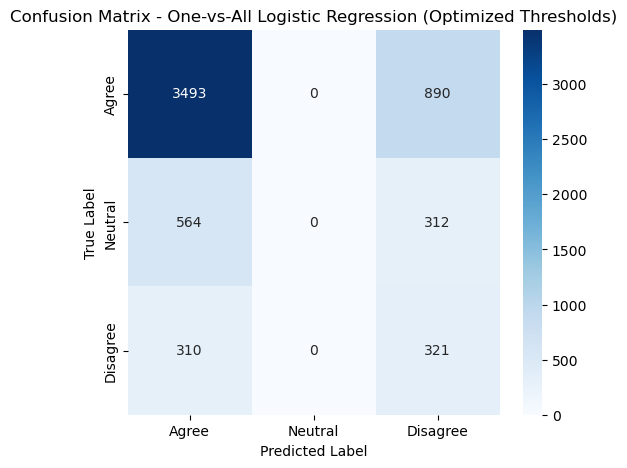

In [129]:
# Overall Evaluation with Optimized Threshold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 1: Compute Precision-Recall Curves to Find Best Thresholds
def find_best_threshold(y_true, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Compute F1 Score
    best_threshold = thresholds[np.argmax(f1_scores)]  # Get threshold with highest F1
    return best_threshold

# Extract binary true labels for each One-vs-All model
y_true_agree = (y_test == 1).astype(int)
y_true_neutral = (y_test == 2).astype(int)
y_true_disagree = (y_test == 3).astype(int)

# Ensure test features are properly formatted
X_test_final = sm.add_constant(X_test_selected_df)

# Get probability predictions from the final logistic regression models
y_prob_agree = final_ova_models["Agree vs Others"].predict(X_test_final)
y_prob_neutral = final_ova_models["Neutral vs Others"].predict(X_test_final)
y_prob_disagree = final_ova_models["Disagree vs Others"].predict(X_test_final)

# Compute best threshold for each class
best_threshold_agree = find_best_threshold(y_true_agree, y_prob_agree)
best_threshold_neutral = find_best_threshold(y_true_neutral, y_prob_neutral)
best_threshold_disagree = find_best_threshold(y_true_disagree, y_prob_disagree)

print(f"🔹 Best Threshold for Agree: {best_threshold_agree:.3f}")
print(f"🔹 Best Threshold for Neutral: {best_threshold_neutral:.3f}")
print(f"🔹 Best Threshold for Disagree: {best_threshold_disagree:.3f}")

# Step 2: Predict Final Class Labels Using Optimized Thresholds
y_pred_final = np.full(len(X_test_final), 2)  # Default class: Neutral

# Assign class labels using the optimized thresholds
y_pred_final[y_prob_agree > best_threshold_agree] = 1  # Assign "Agree"
y_pred_final[y_prob_disagree > best_threshold_disagree] = 3  # Assign "Disagree"

# Step 3: Compute Overall Accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n✅ Final One-vs-All Accuracy (with Threshold Optimization): {final_accuracy:.4f}")

# Step 4: Confusion Matrix
cm_ova = confusion_matrix(y_test, y_pred_final)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ova, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Agree", "Neutral", "Disagree"],
            yticklabels=["Agree", "Neutral", "Disagree"])
plt.title("Confusion Matrix - One-vs-All Logistic Regression (Optimized Thresholds)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### 1-5-3 Hyperparameter Tuning with GridSearchCV
<a id="hyperparameter tuning with GridSearchCV"></a>

To improve the **stability** and **generalization** of logistic regression, **GridSearchCV** was implemented to tune key **hyperparameters**, including **Regularization strength (C)**, **Penalty type (L1 vs. L2)**, **Solver choice (liblinear)**.

After tuning, the **best model** used **L2 regularization (Ridge) with C = 1**, which helped **stabilize coefficient estimates** by preventing extreme values. However, despite these optimizations, the final **accuracy (56.64%)** was **lower** than the baseline logistic regression.

The **confusion matrix** after **threshold optimization** highlights the continued **difficulty in distinguishing Neutral cases**, where almost all Neutral instances were **misclassified** as either: **Agree (487)**, **Disagree (387)**.

Compared to previous models, slightly **better Disagree predictions** were observed, but **Neutral classification remained unreliable**, reinforcing that **logistic regression struggles** with the **middle category in ordinal responses**.


In [132]:
# ======================================
# GridSearchCV for each One-vs-All Model
# ======================================

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

# Ensure feature selection is applied before GridSearchCV
X_train_final = X_train_selected_df  # Use already selected features
y_train_final = y_train  # Use original training labels

# Define One-vs-All Logistic Regression Pipeline
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Standardize features
    ("classifier", OneVsRestClassifier(LogisticRegression(class_weight="balanced", random_state=42)))
])

# Define parameter grid (correctly referencing the estimator inside the pipeline)
param_grid = {
    "classifier__estimator__C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    "classifier__estimator__penalty": ["l1", "l2"],  # Lasso (L1) and Ridge (L2)
    "classifier__estimator__solver": ["liblinear"],  # Solvers supporting L1 & L2
    "classifier__estimator__max_iter": [100, 500, 1000],  # Iterations for convergence
}

# Use Stratified K-Fold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [134]:
best_models = {}
best_scores = {}

# Perform GridSearchCV for each One-vs-All classification task
for class_label, (y_train_bin, y_test_bin) in {
    "Agree": (y_train_agree, y_test_agree),
    "Neutral": (y_train_neutral, y_test_neutral),
    "Disagree": (y_train_disagree, y_test_disagree)
}.items():
    print(f"\n🔹 Tuning Logistic Regression for {class_label} vs Others")

    # Run GridSearchCV
    grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2)
    grid_search.fit(X_train_selected_df, y_train_bin)  # Fit on the selected training data

    # Store Best Model & Score
    best_models[class_label] = grid_search.best_estimator_
    best_scores[class_label] = grid_search.best_score_

    # Print Best Parameters
    print(f"\n✅ Best Hyperparameters for {class_label}: {grid_search.best_params_}")
    print(f"📌 Best CV Accuracy for {class_label}: {grid_search.best_score_:.4f}")

# Display All Results
print("\n📊 Final GridSearchCV Summary:")
for class_label, score in best_scores.items():
    print(f"🔹 {class_label}: Best CV Accuracy = {score:.4f}")



🔹 Tuning Logistic Regression for Agree vs Others
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Best Hyperparameters for Agree: {'classifier__estimator__C': 10, 'classifier__estimator__max_iter': 100, 'classifier__estimator__penalty': 'l1', 'classifier__estimator__solver': 'liblinear'}
📌 Best CV Accuracy for Agree: 0.6287

🔹 Tuning Logistic Regression for Neutral vs Others
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Best Hyperparameters for Neutral: {'classifier__estimator__C': 0.001, 'classifier__estimator__max_iter': 100, 'classifier__estimator__penalty': 'l1', 'classifier__estimator__solver': 'liblinear'}
📌 Best CV Accuracy for Neutral: 0.8513

🔹 Tuning Logistic Regression for Disagree vs Others
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Best Hyperparameters for Disagree: {'classifier__estimator__C': 0.001, 'classifier__estimator__max_iter': 100, 'classifier__estimator__penalty': 'l1', 'classifier__estimator__solver': 'li

In [136]:
print(f"Available keys in ova_targets: {ova_targets.keys()}")

Available keys in ova_targets: dict_keys(['Agree vs Others', 'Neutral vs Others', 'Disagree vs Others'])


Available keys in ova_targets: dict_keys(['Agree vs Others', 'Neutral vs Others', 'Disagree vs Others'])

🔹 Evaluating Agree vs Others
✅ Accuracy for Agree: 0.6221


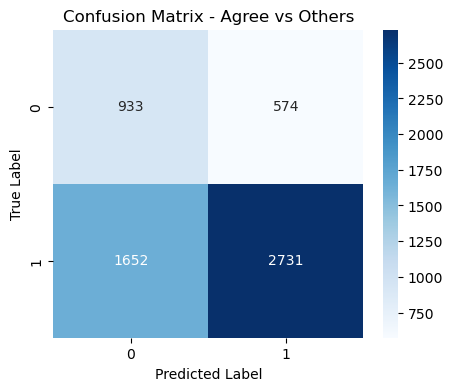


🔹 Evaluating Neutral vs Others
✅ Accuracy for Neutral: 0.8513


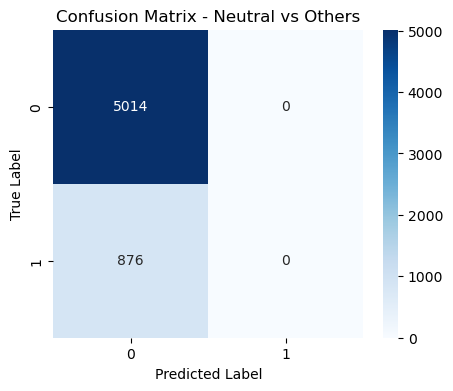


🔹 Evaluating Disagree vs Others
✅ Accuracy for Disagree: 0.4798


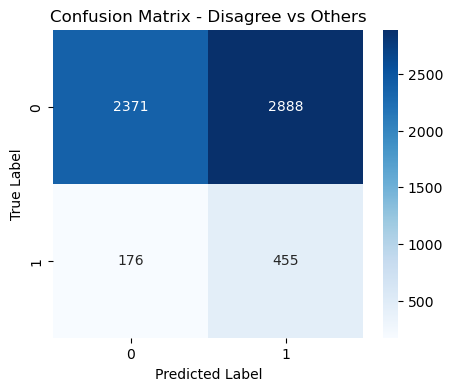


📊 Final Model Evaluation Summary:
🔹 Agree: Accuracy = 0.6221
🔹 Neutral: Accuracy = 0.8513
🔹 Disagree: Accuracy = 0.4798


In [138]:
# Evaluate Each One-vs-All Model
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Store results
model_eval_results = {}

# Check available keys
print(f"Available keys in ova_targets: {ova_targets.keys()}")

# Correct key mapping
key_mapping = {
    "Agree": "Agree vs Others",
    "Neutral": "Neutral vs Others",
    "Disagree": "Disagree vs Others"
}

# Predict and Evaluate Each One-vs-All Model
for class_label, model in best_models.items():
    mapped_key = key_mapping[class_label]  # Ensure correct key mapping

    print(f"\n🔹 Evaluating {class_label} vs Others")

    # Ensure correct test labels
    y_test_bin = ova_targets[mapped_key][1].reset_index(drop=True)  # Get binary labels
    X_test_final = X_test_selected_df  # Use selected test features

    # Predict on test set
    y_pred_bin = model.predict(X_test_final)

    # Compute Accuracy
    accuracy = accuracy_score(y_test_bin, y_pred_bin)
    print(f"✅ Accuracy for {class_label}: {accuracy:.4f}")

    # Compute Confusion Matrix
    cm = confusion_matrix(y_test_bin, y_pred_bin)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {class_label} vs Others")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Store results
    model_eval_results[class_label] = {
        "accuracy": accuracy,
        "confusion_matrix": cm
    }

# Print Final Evaluation Summary
print("\n📊 Final Model Evaluation Summary:")
for class_label, metrics in model_eval_results.items():
    print(f"🔹 {class_label}: Accuracy = {metrics['accuracy']:.4f}")


In [140]:
# Identify Optimized Threshold
from sklearn.metrics import precision_recall_curve
import numpy as np

# Store best thresholds
best_thresholds = {}

# Find Optimal Threshold for Each Class
for class_label, model in best_models.items():
    mapped_key = key_mapping[class_label]  # Ensure correct key mapping

    print(f"\n🔹 Finding Optimal Threshold for {class_label}")

    # Get correct test labels
    y_test_bin = ova_targets[mapped_key][1].reset_index(drop=True)  # Binary labels
    X_test_final = X_test_selected_df  # Use selected test features

    # Ensure the model supports `predict_proba`
    if hasattr(model, "predict_proba"):
        y_prob_bin = model.predict_proba(X_test_final)[:, 1]  # Probability for positive class
    else:
        print(f"⚠️ Warning: Model for {class_label} does not support `predict_proba`. Using `predict` instead.")
        y_prob_bin = model.predict(X_test_final)  # Use raw predictions instead

    # Compute Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test_bin, y_prob_bin)

    # Compute F1 scores for different thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

    # Get best threshold based on highest F1 score
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_thresholds[class_label] = best_threshold

    print(f"✅ Best Threshold for {class_label}: {best_threshold:.3f}")

# Print Final Optimal Thresholds
print("\n📊 Final Optimal Thresholds Summary:")
for class_label, threshold in best_thresholds.items():
    print(f"🔹 {class_label}: {threshold:.3f}")



🔹 Finding Optimal Threshold for Agree
✅ Best Threshold for Agree: 0.201

🔹 Finding Optimal Threshold for Neutral
✅ Best Threshold for Neutral: 0.500

🔹 Finding Optimal Threshold for Disagree
✅ Best Threshold for Disagree: 0.511

📊 Final Optimal Thresholds Summary:
🔹 Agree: 0.201
🔹 Neutral: 0.500
🔹 Disagree: 0.511



✅ Final One-vs-All Accuracy (After Thresholding): 0.5664


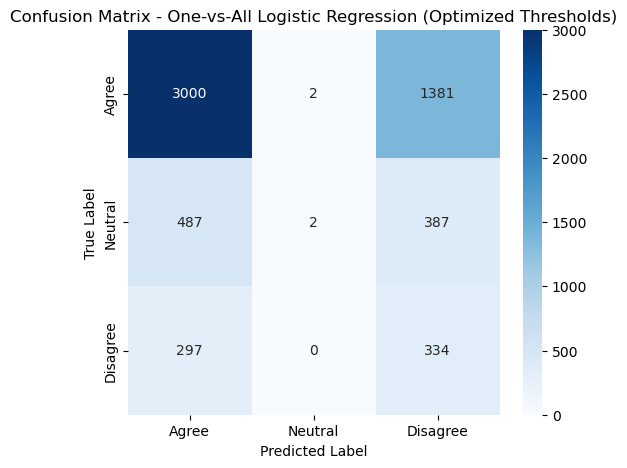

In [142]:
# Overall Evaluation with Optimized Threshold
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure correct feature selection
X_test_final = X_test_selected_df  # Use selected test features

# Default prediction: Neutral (Class 2)
y_pred_final = np.full(len(X_test_final), 2)  

# Compute probability scores for each class (if supported)
y_prob_agree = best_models["Agree"].predict_proba(X_test_final)[:, 1] if hasattr(best_models["Agree"], "predict_proba") else best_models["Agree"].predict(X_test_final)
y_prob_neutral = best_models["Neutral"].predict_proba(X_test_final)[:, 1] if hasattr(best_models["Neutral"], "predict_proba") else best_models["Neutral"].predict(X_test_final)
y_prob_disagree = best_models["Disagree"].predict_proba(X_test_final)[:, 1] if hasattr(best_models["Disagree"], "predict_proba") else best_models["Disagree"].predict(X_test_final)

# ssign class labels based on optimized thresholds
y_pred_final[y_prob_agree > best_thresholds["Agree"]] = 1  # Assign "Agree"
y_pred_final[y_prob_disagree > best_thresholds["Disagree"]] = 3  # Assign "Disagree"

# Compute Overall Accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n✅ Final One-vs-All Accuracy (After Thresholding): {final_accuracy:.4f}")

# Compute Final Confusion Matrix
cm_ova = confusion_matrix(y_test, y_pred_final)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ova, annot=True, fmt="d", cmap="Blues", xticklabels=["Agree", "Neutral", "Disagree"], yticklabels=["Agree", "Neutral", "Disagree"])
plt.title("Confusion Matrix - One-vs-All Logistic Regression (Optimized Thresholds)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [144]:
# Extract coefficients 
import pandas as pd

# Store coefficients and intercepts
coef_dict = {}
intercept_dict = {}

# Extract coefficients from each model
for class_label, model_pipeline in best_models.items():
    print(f"\n🔹 Extracting Coefficients for {class_label} vs Others")

    # Extract OneVsRestClassifier
    one_vs_rest_model = model_pipeline.named_steps["classifier"]

    # Ensure we are accessing the correct logistic regression model
    best_logreg_model = one_vs_rest_model.estimators_[0]  # Extracts the logistic regression estimator

    # Store coefficients and intercepts
    coef_dict[class_label] = best_logreg_model.coef_.flatten()  # Convert to 1D array
    intercept_dict[class_label] = best_logreg_model.intercept_[0]

# Convert to DataFrame for better visualization
coef_df = pd.DataFrame(coef_dict, index=X_train_selected_df.columns)  # Use selected features
intercept_df = pd.DataFrame(intercept_dict, index=["Intercept"])

# Display coefficient table
print("\n🔹 Logistic Regression Coefficients:")
display(coef_df)

# Display intercept table
print("\n🔹 Intercepts:")
display(intercept_df)



🔹 Extracting Coefficients for Agree vs Others

🔹 Extracting Coefficients for Neutral vs Others

🔹 Extracting Coefficients for Disagree vs Others

🔹 Logistic Regression Coefficients:


,Agree,Neutral,Disagree
educ_mob_avg,0.472954,0.0,0.000000
resp_ed,-0.406471,0.0,0.000000
income_decile,-0.232760,0.0,0.074424
marital_status,-0.077643,0.0,0.000000
unemp_ever,0.089761,0.0,0.000000
unemp_nuts2,0.218527,0.0,-0.041622
EQI,-0.159015,0.0,0.000000
wkhtot,-0.059602,0.0,0.000000
gov_trust_mob,-0.162110,0.0,0.000000
equality_mob,-0.284163,0.0,0.000000



🔹 Intercepts:


,Agree,Neutral,Disagree
Intercept,0.096068,0.0,0.0


This analysis highlights the **trade-off between predictive accuracy and interpretability** in modeling attitudes toward **income redistribution**. While **logistic regression** provided clear insights into how **educational mobility, income level, and trust in government** shape preferences, its **predictive performance was limited**, particularly for the **Neutral** and **Disagree** categories. 

**Naïve Bayes** and **ensemble models** (*Random Forest + Naïve Bayes*) improved **classification accuracy to 61.2%**, but no model achieved **consistently strong performance across all classes**. **Predictive models** prioritized **classification accuracy**, while **interpretive models** revealed key **socioeconomic influences** on redistribution attitudes.

Ultimately, **future research** should explore more **flexible approaches**, such as **interpretable machine learning** or **hierarchical models**, to better capture both **predictive power** and **explanatory depth**.

## 5. Limitations
<a id="limitations"></a>

This analysis has several limitations that stem from both **data constraints** and **methodological challenges**. 

First, the dependent variable (`inc_redist`) exhibits significant **class imbalance**, where approximately **74%** of respondents favor redistribution, while only **15%** are neutral and **10%** disagree. This imbalance reflects both **real-world attitudes** as redistribution policies tend to have broad support and **survey biases**, such as overrepresentation of particular demographic groups or socially desirable responses (**King & Zeng, 2001**). The difficulty in predicting **Neutral** and **Disagree** categories suggests that these groups may be more heterogeneous, requiring additional predictors or different modeling strategies.

Second, **feature selection** and **model specification challenges** may have influenced results. While **educational mobility** was the primary predictor of interest, **regional** and broader **socioeconomic factors** often dominated its effect, making it harder to isolate its true impact. This aligns with previous research showing that **structural economic conditions** and **institutional trust** often play a more significant role in shaping redistributive preferences than individual-level characteristics (**Gelman & Hill, 2007**). The models also assume that attitudes toward redistribution are shaped by **observable factors**, but **unmeasured variables** such as political ideology, exposure to inequality, or personal economic experiences were not included, potentially introducing **omitted variable bias**.

Third, the reliance on **categorical variable coding** and **logistic regression modeling** presents constraints in **granularity** and **interpretation**. The logistic regression model, while interpretable, assumes **linearity in the log-odds relationship**, which may oversimplify complex interactions between socioeconomic factors. Additionally, the categorization of **income redistribution preferences** into three discrete classes may lose information about the **intensity** of respondents' views, as **ordinal** or **continuous scaling** could better capture gradual shifts in opinion. Future research could explore **hierarchical** or **latent variable models** to better account for underlying heterogeneity in preferences (**Hastie et al., 2009**).

Lastly, **modeling performance** varied significantly across different approaches, highlighting the **trade-off between interpretability and predictive power**. While **logistic regression** allowed for coefficient interpretation, its performance in predicting minority classes was weak. **Naïve Bayes** provided better handling of class probabilities but suffered from **oversimplified assumptions**, and ensemble methods like **Random Forest** improved accuracy for the majority class but remained ineffective in predicting **Neutral** and **Disagree** responses. These limitations suggest that future studies should consider a **combination of interpretable models** with more **flexible machine learning approaches**, such as **XGBoost** or **LightGBM**, while ensuring that **class imbalance** and **feature dominance** do not distort conclusions.



## 6. Summary
<a id="summary"></a>
This analysis examined the determinants of income redistribution preferences, emphasizing the influence of income, educational mobility, and trust in government. These findings align with prior studies, suggesting that geographical, demographic, and economic factors play critical roles in shaping redistribution preferences. Based on these findings, policymakers should focus on addressing unemployment, promoting educational equity, and tailoring redistribution policies to regional needs. Additionally, businesses can align corporate social responsibility (CSR) initiatives with regional disparities, focusing on education and workforce development. While this analysis successfully identifies key socioeconomic determinants of redistributive preferences, the dataset’s imbalance, feature interactions, and modeling constraints present challenges in both predictive performance and interpretability. Addressing these limitations in future work—through improved data collection, alternative modeling strategies, and better handling of heterogeneity, which could provide deeper insights into public attitudes toward redistribution.


## 7. References
<a id="references"></a>
Alesina, A., & Giuliano, P. (2011). Preferences for redistribution. Handbook of Social Economics, 1A, 93–131.

Alesina, A., Stantcheva, S., & Teso, E. (2018). Intergenerational mobility and preferences for redistribution. American Economic Review, 108(2), 521–554. https://doi.org/10.1257/aer.20162015

Charron, N., Lapuente, V., Bauhr, M., & Annoni, P. (2022). Change and continuity in quality of government: Trends in subnational quality of government in EU member states. Investigaciones Regionales-Journal of Regional Research, 2022(53), 5–23. https://doi.org/10.38191/iirr-jorr.22.008

European Social Survey (ESS). (2024). ESS10 Multilevel Data, edition 1.0. ESS Data Portal. https://ess.sikt.no/en/datafile/1ae049b3-0bc3-408e-91a0-0546b2d02cce/35?tab=0

Gelman, A., & Hill, J. (2007). Data analysis using regression and multilevel/hierarchical models. Cambridge University Press.

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning. Springer.

Jerrim, J., & Macmillan, L. (2015). Income inequality, intergenerational mobility, and the Great Gatsby Curve: Is education the key? Social Forces, 94(2), 505–533. https://doi.org/10.1093/sf/sov075

King, G., & Zeng, L. (2001). Logistic regression in rare events data. Political Analysis, 9(2), 137–163.

Knack, S., & Keefer, P. (1997). Does social capital have an economic payoff? A cross-country investigation. The Quarterly Journal of Economics, 112(4), 1251–1288. https://doi.org/10.1162/003355300555475

Lindh, A., & Andersson, A. B. (2024). Social networks and distributive conflict: The class divide in social ties and attitudes to income inequality across 29 countries. European Sociological Review, XX, 1–16. https://doi.org/10.1093/esr/jcae039

## 8. Appendix
<a id="appendix"></a>

### 8-1. Table
<a id="table"></a>

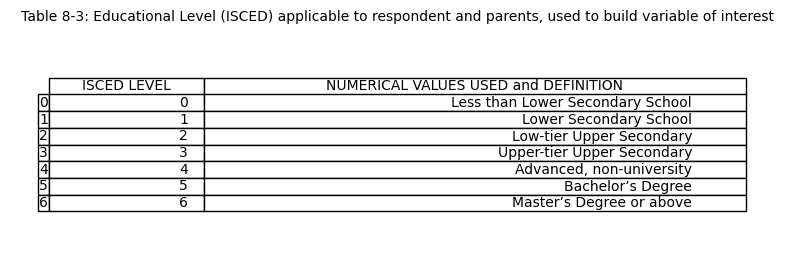

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Data for the table
data = {
    "ISCED LEVEL": [0, 1, 2, 3, 4, 5, 6],
    "NUMERICAL VALUES USED and DEFINITION": [
        "Less than Lower Secondary School",
        "Lower Secondary School",
        "Low-tier Upper Secondary",
        "Upper-tier Upper Secondary",
        "Advanced, non-university",
        "Bachelor’s Degree",
        "Master’s Degree or above",
    ],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust figure size as needed
ax.axis("tight")
ax.axis("off")

# Create the table
table(ax, df, loc="center", colWidths=[0.2, 0.7])  # Adjust column width as needed

# Add title
plt.title("Table 8-3: Educational Level (ISCED) applicable to respondent and parents, used to build variable of interest", fontsize=10)

# Save the table as an image (optional)
plt.savefig("educational_level_table.png", bbox_inches="tight", dpi=300)

# Show the table
plt.show()